In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

## 2024.06.15

In [26]:
fnames = get_files_by_criteria(date_filters=["2024-06-15"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 14 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-15\11\000014954-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-15\11\000014954-GeneralVariableScan_microwave_Rabi_scan_over_AZ_top_volts_OP.h5) scanned over AZ_top_volts_OP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-15\12\000014963-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-15\12\000014967-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-15\12\000014967-GeneralVariableScan_microwave_Rabi_scan_over_AZ_top_volts_OP.h5) scanned over AZ_top_volts_OP
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-15\13\000014968-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 6 (C:\Networking Experiment\artiq codes\

### coil scan for OP optimization
minimizing the retention vs OP coils with a microwave experiment. after pumping into |1,0>, microwaves drive population into |2,0>, and we want to maximize the population transfer (minimize number of atoms that survive the blow-away), which corresponds to maximizing the population accumulation in |1,0>. The Y coil is set to give about 1 G.

experiment: microwave_Rabi_experiment
AY_volts_OP: 2.0


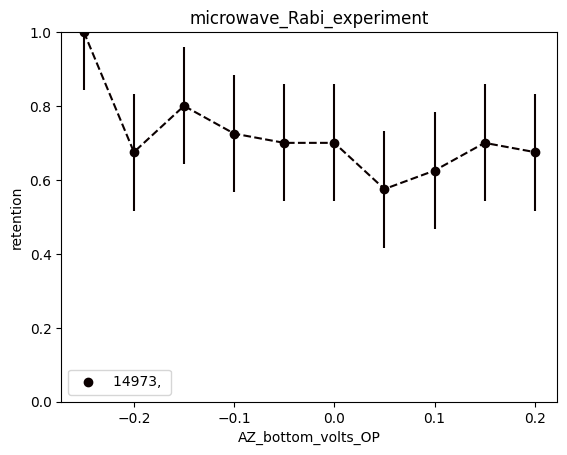

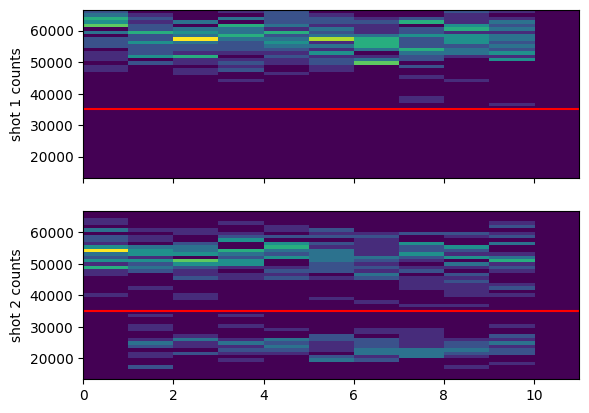

In [27]:
compare = True # compare multiple files in the same retention and loading plots

# Z top coil scans
file_indices = {
    9: '',
    11: ''
} # the files to plot

# Z bottom coil scans
file_indices = {
    13: ''
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: 816.656 - 2*x - 92.65

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1=cutoff2 = 35000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.06.14

In [16]:
fnames = get_files_by_criteria(date_filters=["2024-06-14"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 80 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\07\000014866-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\07\000014869-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\07\000014869-GeneralVariableScan_optical_pumping_scan_over_p_D1_pumping_SP.h5) scanned over p_D1_pumping_SP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\08\000014870-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\08\000014870-GeneralVariableScan_optical_pumping_scan_over_p_D1_pumping_SP.h5) scanned over p_D1_pumping_SP
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\08\000014872-GeneralVariableScan.h5) scanned over dummy_variable
file 6 (C:\Networking Experiment\artiq codes

### coil scan for OP optimization
minimizing the retention vs OP coils with a microwave experiment. after pumping into |1,0>, microwaves drive population into |2,0>, and we want to maximize the population transfer (minimize number of atoms that survive the blow-away), which corresponds to maximizing the population accumulation in |1,0>. The Y coil is set to give about 1 G.

experiment: microwave_Rabi_experiment
AY_volts_OP: 2.0
experiment: microwave_Rabi_experiment
AY_volts_OP: 2.0


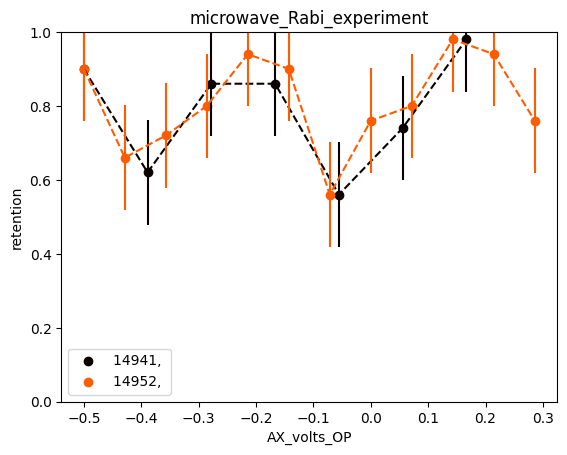

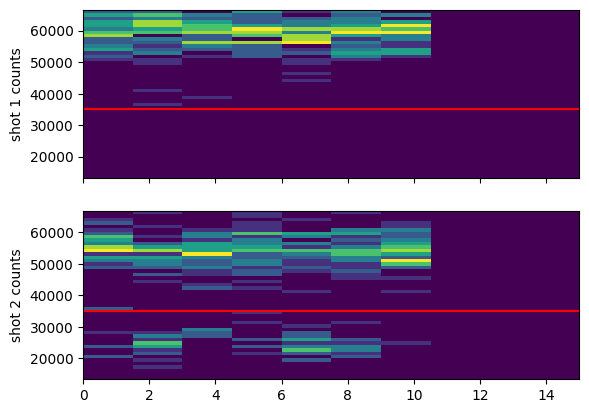

In [20]:
compare = True # compare multiple files in the same retention and loading plots

# X coil scans
file_indices = {
    75: '',
    79: ''
} # the files to plot

# # Z coil scans
# file_indices = {
#     77: '',
# } # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: 816.656 - 2*x - 92.65

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1=cutoff2 = 35000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [22]:
scan_sequence1

array([-0.5       , -0.42857143, -0.35714286, -0.28571429, -0.21428571,
       -0.14285714, -0.07142857,  0.        ,  0.07142857,  0.14285714,
        0.21428571,  0.28571429,  0.35714286,  0.42857143,  0.5       ])

### pulse time scans

experiment: microwave_Rabi_experiment
AY_volts_OP: 2.0
experiment: microwave_Rabi_experiment
AY_volts_OP: 2.0


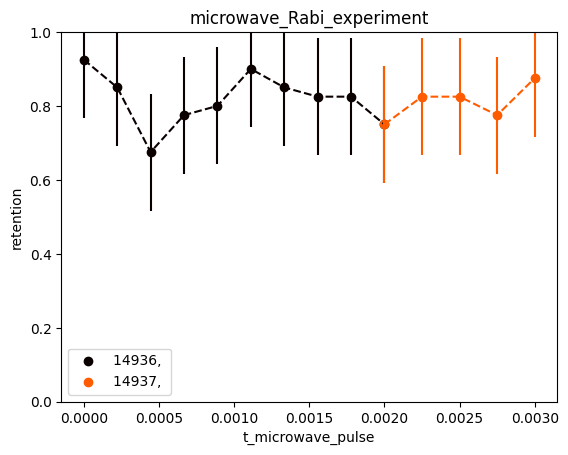

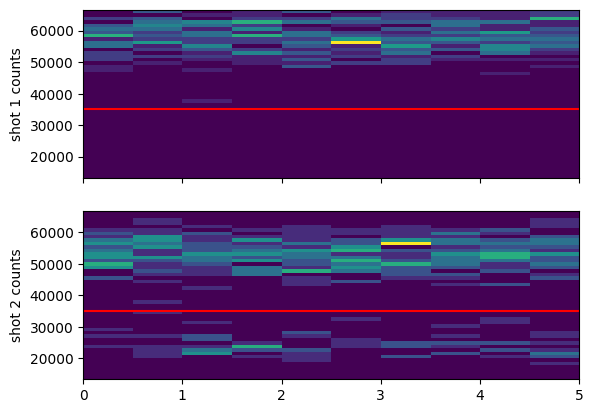

In [10]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    67: '',
    69: ''
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: 816.656 - 2*x - 92.65

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1=cutoff2 = 35000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### frequency scans

experiment: microwave_Rabi_experiment
AY_volts_OP: 2.0


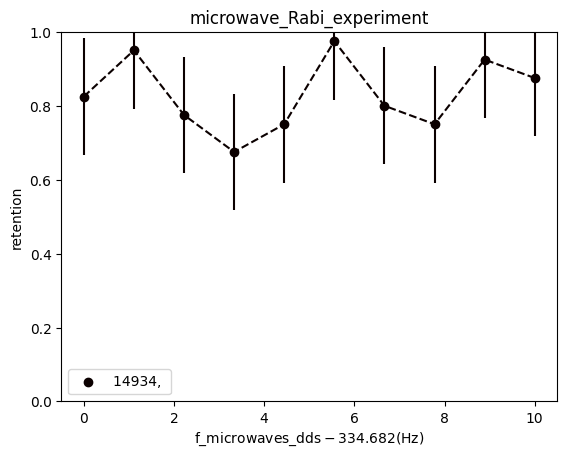

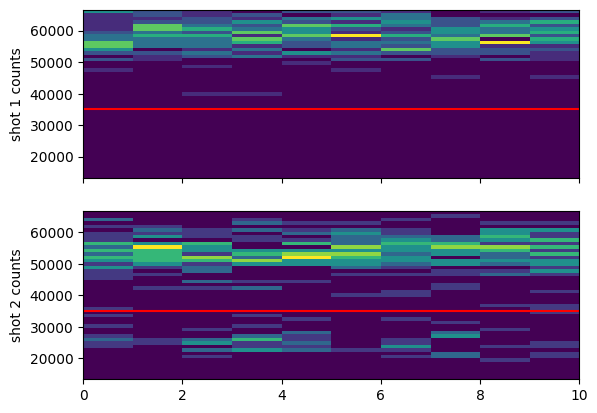

In [12]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    65: '',
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1=cutoff2 = 35000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [13]:
np.linspace(0,2000,10)*us

array([0.        , 0.00022222, 0.00044444, 0.00066667, 0.00088889,
       0.00111111, 0.00133333, 0.00155556, 0.00177778, 0.002     ])

## 2024.06.06

## trying to get good population transfer
The optical pumping last week was found not be optimized, and I'm tuning the coils now using a microwave rotation instead of depump measurement to optimize this.

In [29]:
fnames = get_files_by_criteria(date_filters=["2024-06-06"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 12 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-06\13\000014521-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-06\15\000014553-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-06\15\000014557-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-06\20\000014587-GeneralVariableScan.h5) scanned over f_microwaves
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-06\20\000014588-GeneralVariableScan.h5) scanned over f_microwaves
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-06\20\000014588-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves.h5) scanned over f_microwaves
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-06\21\000014590-GeneralV

### frequency scans

experiment: microwave_Rabi_experiment
AZ_bottom_volts_OP=0.0, AZ_top_volts_OP=0.0, AX_volts_OP=0.0, AY_volts_OP=-6.2
p_D1_pumping_SP=-25.0, t_pumping=1000.00 us
experiment: microwave_Rabi_experiment
AZ_bottom_volts_OP=0.0, AZ_top_volts_OP=0.0, AX_volts_OP=0.0, AY_volts_OP=-6.2
p_D1_pumping_SP=-25.0, t_pumping=1000.00 us
experiment: microwave_Rabi_experiment
AZ_bottom_volts_OP=0.0, AZ_top_volts_OP=0.0, AX_volts_OP=0.0, AY_volts_OP=-6.2
p_D1_pumping_SP=-25.0, t_pumping=1000.00 us
experiment: microwave_Rabi_experiment
AZ_bottom_volts_OP=0.0, AZ_top_volts_OP=0.0, AX_volts_OP=0.0, AY_volts_OP=-6.2
p_D1_pumping_SP=-25.0, t_pumping=1000.00 us


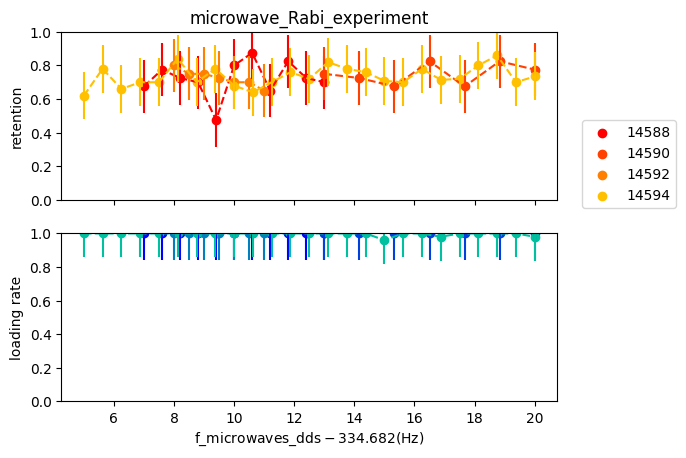

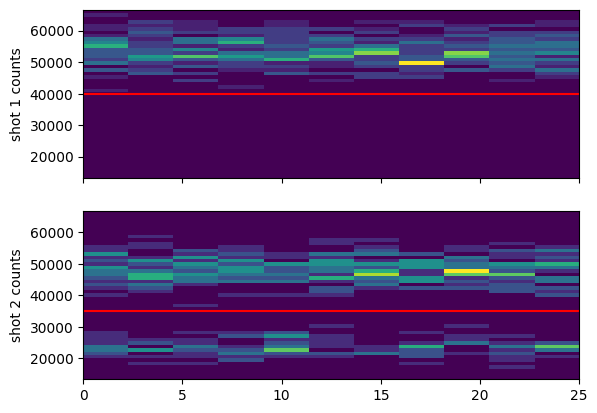

In [30]:
file_indices = [5,6,9,11] # the files to plot

showhist = True
showloading = True
showOPparams = True

if showloading:
    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
    ax_ret, ax_ldng = axes
else:
    fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['autumn']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1 = 40000*t_SPCM_first_shot
    cutoff2 = 35000*t_SPCM_second_shot

    if showOPparams:
        print(f"AZ_bottom_volts_OP={AZ_top_volts_OP}, AZ_top_volts_OP={AZ_top_volts_OP}, AX_volts_OP={AX_volts_OP}, AY_volts_OP={AY_volts_OP}")
        print(f"p_D1_pumping_SP={p_D1_pumping_SP}, t_pumping={t_pumping*1e6:.2f} us")
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        # ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color=ret_cmap(idx/len(file_indices)))
        # ax_ret.scatter(xsteps_xform(scan_sequence1), retention,label=rid, color=ret_cmap(idx/len(file_indices)))
        # errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        # ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=rid, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.06.04

## trying to get good population transfer
The optical pumping last week was found not be optimized, and I'm tuning the coils now using a microwave rotation instead of depump measurement to optimize this.

In [16]:
fnames = get_files_by_criteria(date_filters=["2024-06-04"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\13\000014439-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5, which is corrupt
found 9 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014434-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014434-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014435-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014435-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014438-GeneralVariableScan.h5) scanned over f_microwaves_dds
fi

### frequency scans

experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment


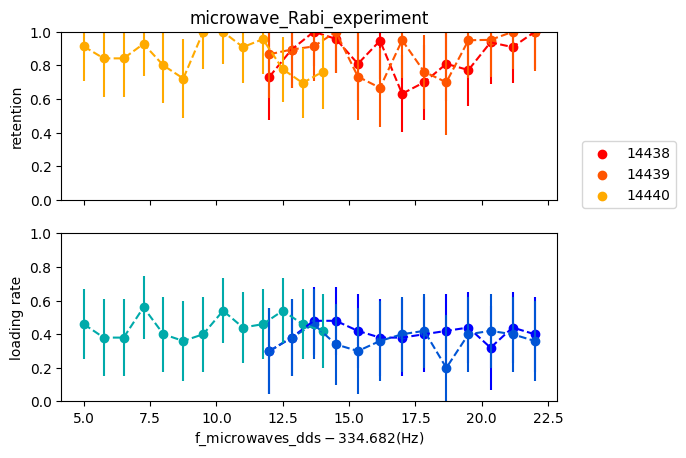

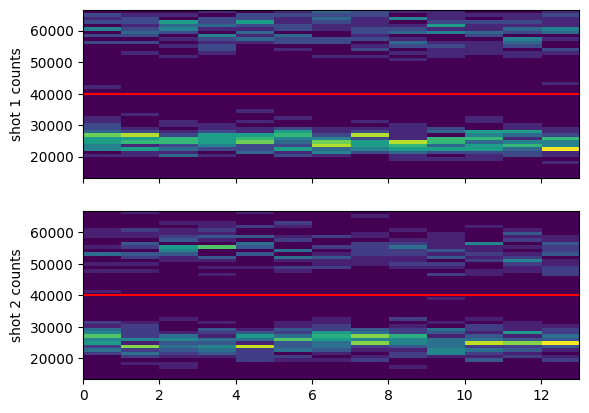

In [17]:
file_indices = [5,6,7] # the files to plot

showhist = True
showloading = True

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if showloading:
    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
    ax_ret, ax_ldng = axes
else:
    fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['autumn']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        # ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color=ret_cmap(idx/len(file_indices)))
        # ax_ret.scatter(xsteps_xform(scan_sequence1), retention,label=rid, color=ret_cmap(idx/len(file_indices)))
        # errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        # ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=rid, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### pulse time scans

experiment: microwave_Rabi_experiment
[]


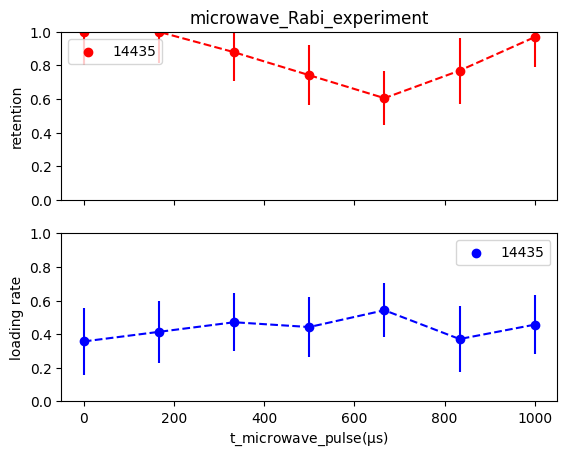

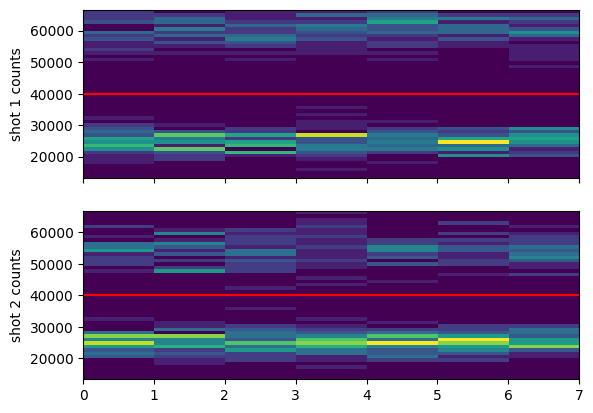

In [14]:
file_indices = [3] # the files to plot

showhist = True
showloading = True

if showloading:
    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
    ax_ret, ax_ldng = axes
else:
    fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['autumn']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"$\rm{t\_microwave\_pulse} (\mu s)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x)*1e6 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1=cutoff2 = 40000*t_SPCM_first_shot
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        # ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color=ret_cmap(idx/len(file_indices)))
        # ax_ret.scatter(xsteps_xform(scan_sequence1), retention,label=rid, color=ret_cmap(idx/len(file_indices)))
        # errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        # ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=rid, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        print(scan_sequence1[retention < 0.6])
        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend()
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            ax_ldng.legend()
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.05.24

## looking for a microwave signal
See the section below. I parked the dds frequency at 1 kHz > than the clock frequency per the frequency scan, and did a course scan over the microwave pulse time. It looks like there is indeed something real, but the oscillation (if you can call it that) is low contrast. The experiment is pumping the atom into F=1,m=0, doing a microwave pulse (which may not be on the 0-0 transition given how small of a detuning I'm using; maybe this is an off-resonant weak driving of one of the other hyperfine transitions) which should transfer population to an F=2 state, and then subsequently be blown away. So at t = 0, the atoms should mostly survive, while at t % t_pi == 0, the atoms should all be blown away.

In [114]:
fnames = get_files_by_criteria(date_filters=["2024-05-2"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 20 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\18\000013977-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-21\08\000013978-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-21\08\000013979-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-21\09\000013980-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-23\16\000014133-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 5 (C:\Networking Experiment\artiq codes\artiq-ma

In [90]:
scan_sequence1 - 334.682*MHz

array([20000.        , 20666.66666669, 21333.33333331, 22000.        ,
       22666.66666669, 23333.33333331, 24000.        , 24666.66666669,
       25333.33333331, 26000.        ])

### frequency scans

experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment


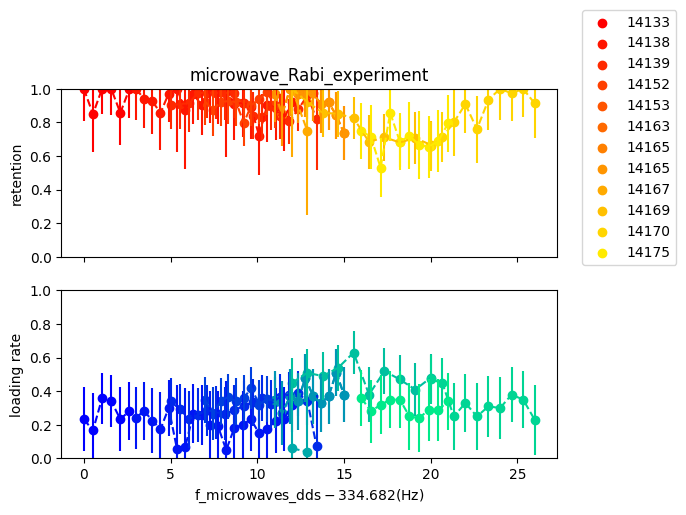

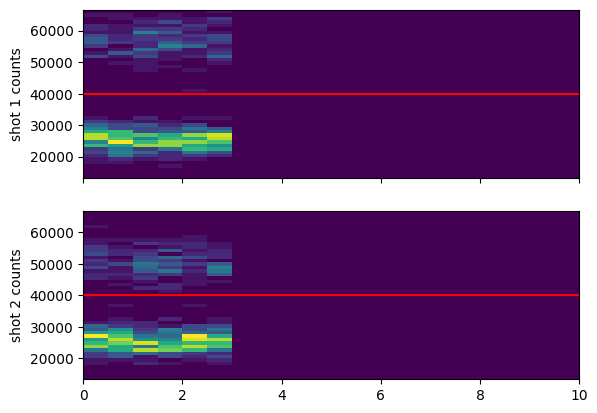

In [115]:
# all of these are frequency scans with pulse time 250 us (some yesterday might be 200 us) until 14170 (16). 
# after that, the pulse time is 555 us. 
file_indices = [4,5,6,9,10,11,12,12,14,15,16,19] # the files to plot

showhist = True
showloading = True

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if showloading:
    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
    ax_ret, ax_ldng = axes
else:
    fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['autumn']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        # ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color=ret_cmap(idx/len(file_indices)))
        # ax_ret.scatter(xsteps_xform(scan_sequence1), retention,label=rid, color=ret_cmap(idx/len(file_indices)))
        # errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        # ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=rid, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### pulse time scans

experiment: microwave_Rabi_experiment
[0.00055556]
experiment: microwave_Rabi_experiment
[0.00144444 0.00155556 0.00166667 0.00177778 0.00188889 0.002     ]


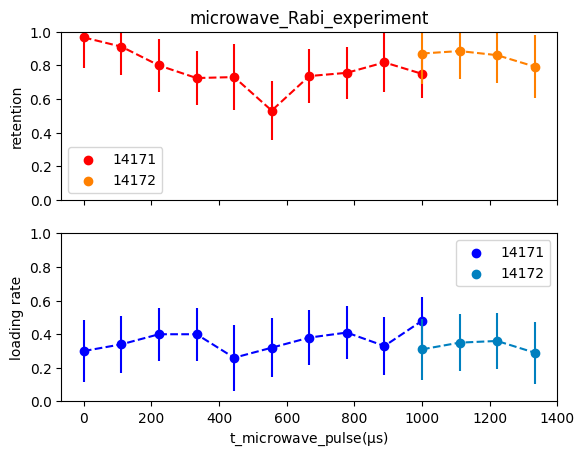

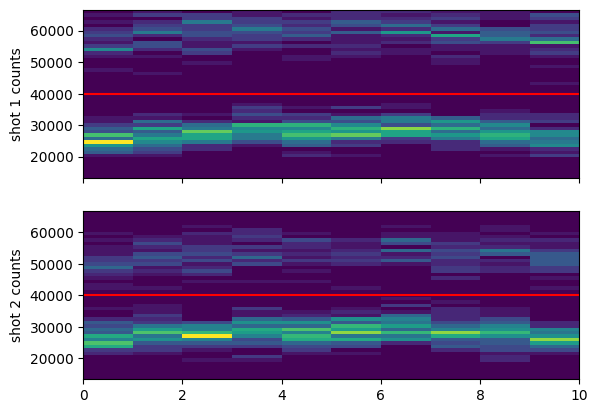

In [116]:
file_indices = [17, 18] # the files to plot

showhist = True
showloading = True

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if showloading:
    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
    ax_ret, ax_ldng = axes
else:
    fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['autumn']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"$\rm{t\_microwave\_pulse} (\mu s)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x)*1e6 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        # ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color=ret_cmap(idx/len(file_indices)))
        # ax_ret.scatter(xsteps_xform(scan_sequence1), retention,label=rid, color=ret_cmap(idx/len(file_indices)))
        # errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        # ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=rid, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        print(scan_sequence1[retention < 0.6])
        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend()
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            ax_ldng.legend()
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [71]:
3.34964e8 - 334.682e6

282000.0

In [74]:
(np.linspace(5,15,20)*kHz)[7]

8684.21052631579

## 2024.05.21

## looking for a microwave signal
See the section below. I parked the dds frequency at 1 kHz > than the clock frequency per the frequency scan, and did a course scan over the microwave pulse time. It looks like there is indeed something real, but the oscillation (if you can call it that) is low contrast. The experiment is pumping the atom into F=1,m=0, doing a microwave pulse (which may not be on the 0-0 transition given how small of a detuning I'm using; maybe this is an off-resonant weak driving of one of the other hyperfine transitions) which should transfer population to an F=2 state, and then subsequently be blown away. So at t = 0, the atoms should mostly survive, while at t % t_pi == 0, the atoms should all be blown away.

In [4]:
fnames = get_files_by_criteria(date_filters=["2024-05-2"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 3 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\18\000013977-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-21\08\000013978-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-21\08\000013979-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds


experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment
experiment: microwave_Rabi_experiment


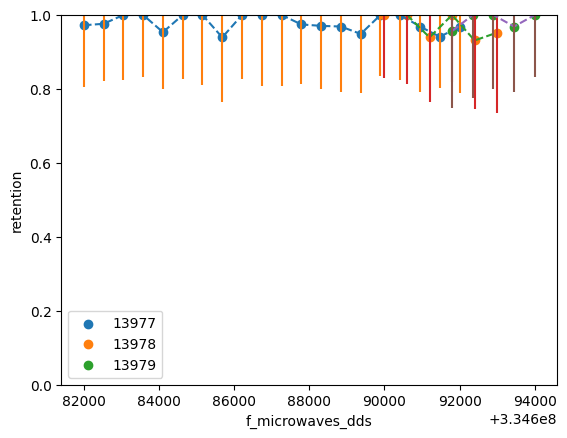

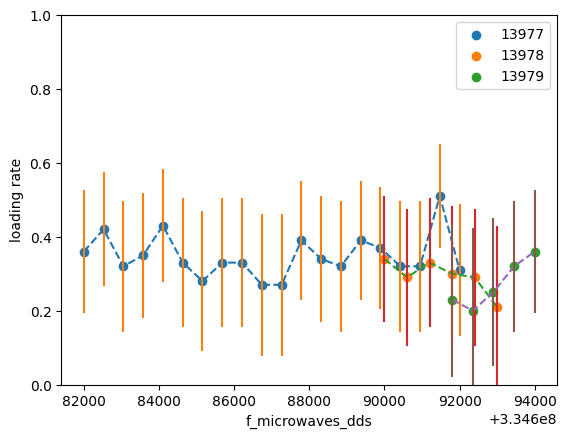

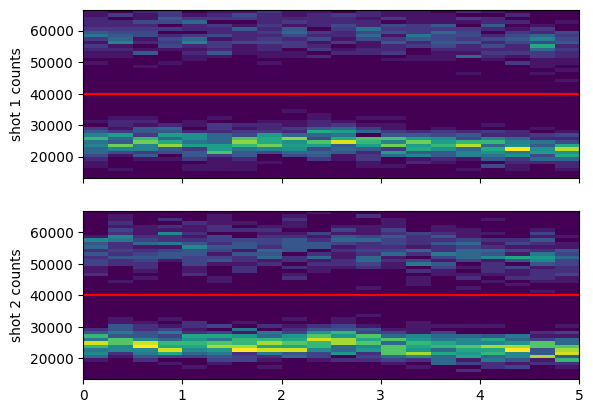

In [44]:
showhist = True
showloading = True

units = None

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

fig_ret,ax_ret = plt.subplots()
fig_ldng,ax_ldng = plt.subplots()

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for i in [0,1,2]:
    f = h5py.File(os.path.join(results, fnames[i]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = int(len(photocounts)/n_measurements)
        
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        ax_ret.plot(scan_sequence1, retention,linestyle='--')
        ax_ret.scatter(scan_sequence1, retention,label=rid)
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        ax_ret.errorbar(scan_sequence1, retention, errs, ls='none')
        ax_ret.set_ylim((0,1))
    
        ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(scan_sequence1, loading,linestyle='--')
            ax_ldng.scatter(scan_sequence1, loading,label=rid)
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            ax_ldng.errorbar(scan_sequence1, loading, errs, ls='none')
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            ax_ldng.legend()

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

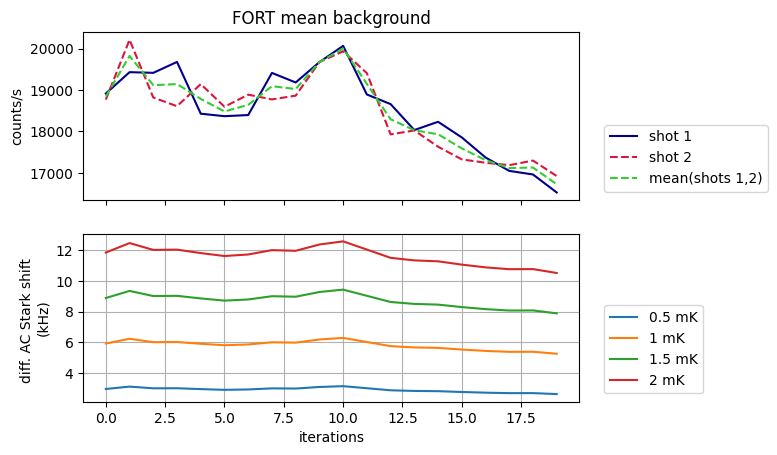

In [65]:
# how much is the stark shift changing over these experiments?
# subtract the mean non-FORT background from the background during readout

nonFORT_bg = 5600
mean_bg1 = np.array(mean1_by_iteration[0]).flatten()-nonFORT_bg
mean_bg2 = np.array(mean2_by_iteration[0]).flatten()-nonFORT_bg
mean_mean_bg = np.mean([mean_bg1, mean_bg2],axis=0)
fig,axes = plt.subplots(nrows=2,sharex=True)
ax,ax2 = axes
ax.plot(mean_bg1,color='darkblue',label='shot 1')
ax.plot(mean_bg2,color='crimson',ls='--',label='shot 2')
ax.plot(mean_mean_bg,color='limegreen',ls='--',label='mean(shots 1,2)')

# the minimum FORT background should correspond to the polarization being the most aligned to the polarizer behind the mirror,
# because when the polarization is misaligned, the AOM feedback will send more power to the SM fiber because it can't distinguish
# polarization from amplitude drift

c = 2.998e8
d1 = 2*np.pi*c*(1/794.978850e-9 - 1/852e-9)
d2 = 2*np.pi*c*(1/780.241209e-9 - 1/852e-9)
d_eff = 1/((1/d1 + 2/d2)/3) # weighted average of D lines. # see Oscillator strengths of the principal series lines of Rb", table 3
kB = 1.38e-23
hbar = 6.06e-34
omega_hfs = 2*np.pi*6.834682e9

eta = omega_hfs/d_eff # see "Analysis of dephasing mechanisms in a standing-wave dipole trap" by Meschede group
for TFORT in [0.5,1,1.5,2]:
# TFORT = 1e-3 # our guess at the trap depth in K. not sure what our error bars are.

    diff_shift = eta*TFORT*1e-3*kB/hbar
    acstark = (diff_shift*1e-3)*mean_mean_bg/np.min(mean_mean_bg)
    ax2.plot(acstark,label=f'{TFORT} mK')
ax2.grid()
ax2.set_ylabel("diff. AC Stark shift \n(kHz)")

ax.set_title("FORT mean background")
ax.set_ylabel("counts/s")
ax2.set_xlabel("iterations")

for axis in axes:
    axis.legend(loc=(1.05,0.05))
plt.show()

## 2024.05.01

## microwave Rabi flopping?
See the section below. I parked the dds frequency at 1 kHz > than the clock frequency per the frequency scan, and did a course scan over the microwave pulse time. It looks like there is indeed something real, but the oscillation (if you can call it that) is low contrast. The experiment is pumping the atom into F=1,m=0, doing a microwave pulse (which may not be on the 0-0 transition given how small of a detuning I'm using; maybe this is an off-resonant weak driving of one of the other hyperfine transitions) which should transfer population to an F=2 state, and then subsequently be blown away. So at t = 0, the atoms should mostly survive, while at t % t_pi == 0, the atoms should all be blown away.

In [7]:
fnames = get_files_by_criteria(date_filters=["2024-05-01"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 2 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-01\07\000012760-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-01\07\000012761-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse


In [12]:
fname = fnames[1] # first (really bad) Rabi oscillation?

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Pumping light off? False


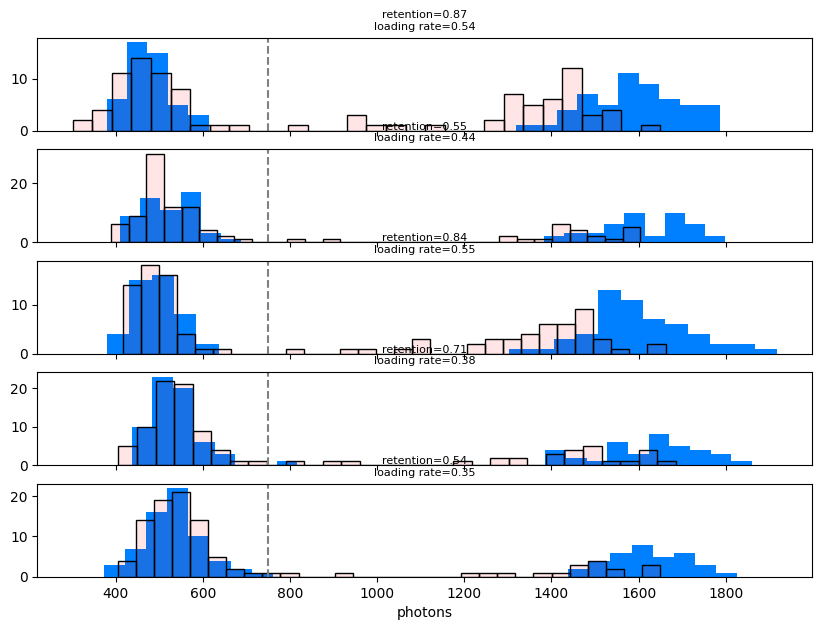

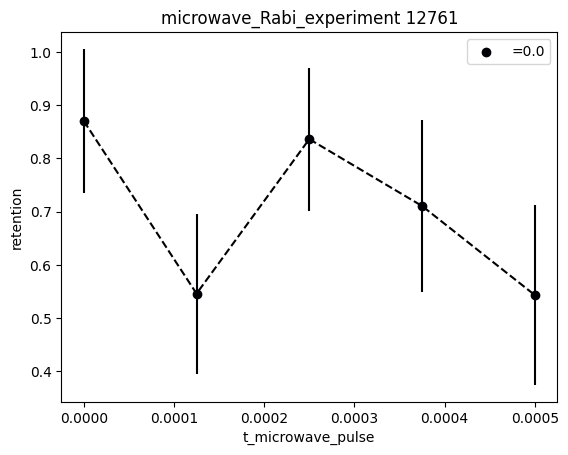

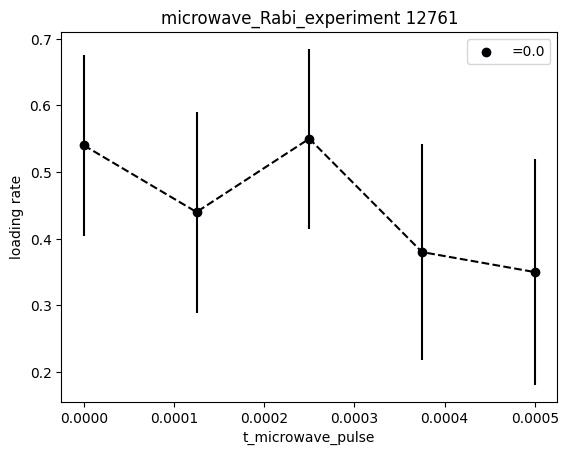

In [13]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

## microwave spectroscopy with optical pumping on
since I have recently gotten optical pumping to 99% fidelity based on comparing the pump/depump time constants, I decided to run another microwave spectroscopy scan. the microwave experiment is now the current optical pumping experiment, with a microwave pulse between the pumping and blowaway phases.

In [14]:
fnames = get_files_by_criteria(date_filters=["2024-04-30"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 1 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-30\18\000012759-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds


In [15]:
fname = fnames[0] # optical pumping has been consistent so these features are probably real

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Pumping light off? False


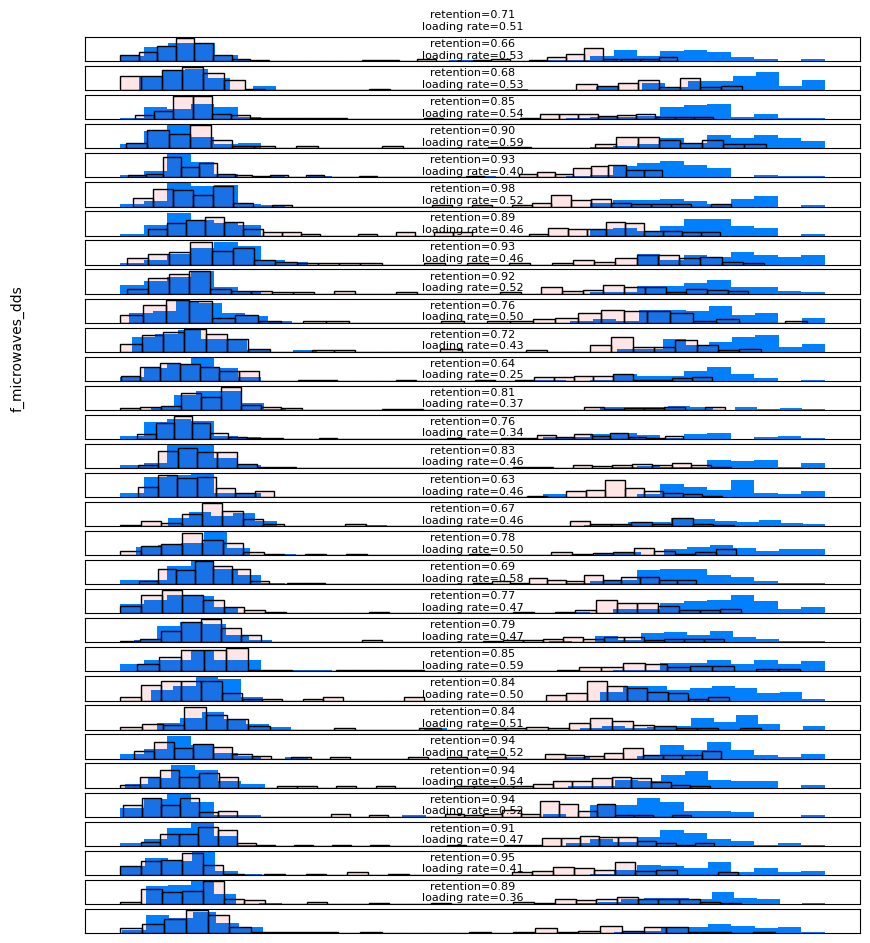

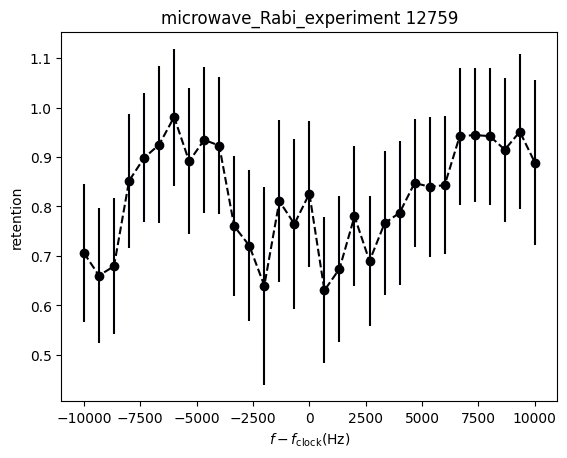

In [18]:
showhist = True
showloading = False # set to false when comparing multiple files
scan_offset = f_microwaves_dds
# scan_offset = 0

# don't try to compare multiple files if the scan is 2D
filelist=[
    fname
]

user_defined_cutoffs = False
cutoff1 = cutoff2 = 800


for f_idx, fname in enumerate(filelist):
    f = h5py.File(os.path.join(results, fname))
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    iterations = len(scan_sequence1)*len(scan_sequence2)

    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    if not user_defined_cutoffs:
        cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
        cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
    if scan_is_2D:
        dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            # ax.set_ylabel("occurences")
            # ax.set_xlabel("photons")
            ax.set_xticks([])
            ax.set_yticks([])
        if scan_is_2D: # todo
            axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
            [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
            [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
            [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
        fig.text(0.45,-0.5, scan_variable2_name)
        fig.text(0.05,0.35, scan_variable1_name,rotation=90)
        plt.subplots_adjust(bottom=-0.4)
        plt.show()
    
    if scan_is_2D:
        # plot a colormap of the retention
        fig,ax = plt.subplots()
        cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                      extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
        im = ax.get_images()
        extent =  im[0].get_extent()
        # plt.setp(ax.spines.values(), linewidth=0.1)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
        ax.set_xticks(scan_sequence1)
        ax.set_yticks(scan_sequence2)
        ax.set_title(experiment_function)
        ax.set_xlabel(scan_variable1_name)
        ax.set_ylabel(scan_variable2_name)
        # ax.tick_params(axis='both', labelsize=10)
        fig.colorbar(cax)
        # plt.clim(0,1)
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if scan_is_2D:
            color=cmap(i/len(scan_sequence2))
            label=scan_variable2_name+"="+str(var2)
        else:
            color=cmap(f_idx/len(filelist))
            label=f"file {f_idx}"
        
        plt.plot(scan_sequence1-scan_offset, retention,color=color,linestyle='--')
        plt.scatter(scan_sequence1-scan_offset, retention,color=color,label=label)
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1-scan_offset, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
        # plt.xlim((-7500,-2500))
        # plt.savefig("")
    
        if len(scan_sequence2)>1 or len(filelist)>1:
            plt.legend()
        plt.title(experiment_function+f' {rid}')
        # plt.title("microwave spectroscopy")
        # plt.savefig("first_microwave_spectroscopy_signal_expid000012164.png",bbox_inches='tight')
        # plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1-scan_offset, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            # plt.xlabel(scan_variable1_name)
            plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function)
            plt.show()
plt.show()

## 2024.04.23

## microwave spectroscopy
the atoms are hot, and we want to zero the B fields at the atoms with microwaves, but finding the microwave dip when the atoms have not been pumped into a single hyperfine state (at least partially) is going to be tough.

In [187]:
fnames = get_files_by_criteria(date_filters=["2024-04-23"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 3 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-23\09\000012310-GeneralVariableScan_microwave_Rabi.h5) scanned over t_microwave_pulse
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-23\09\000012312-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-23\12\000012331-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds


In [188]:
fname = fnames[0] # trying to do a Rabi oscilation using frequency found last night
fname = fnames[2] # the double pass AOM alignment was done incorrectly, but is fixed now


f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Pumping light off? True


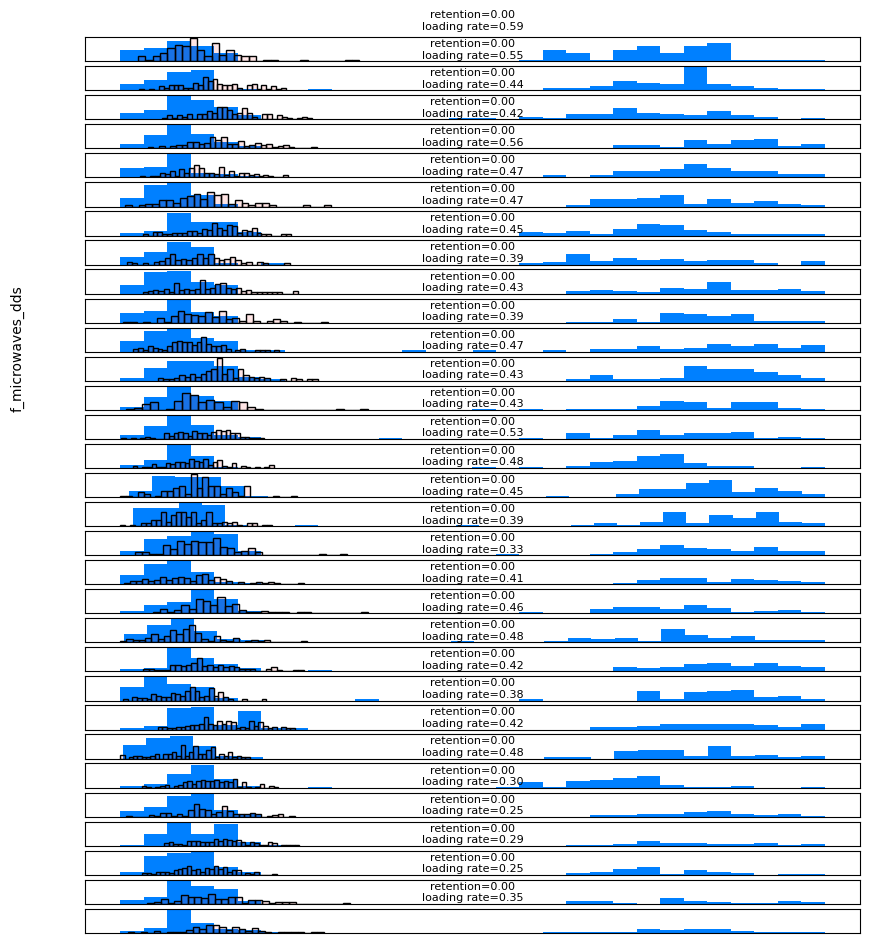

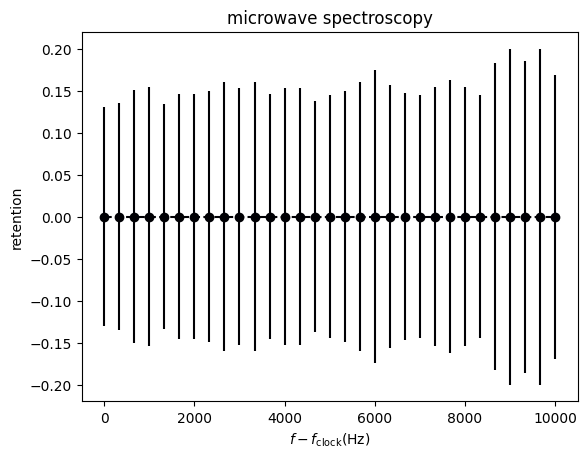

In [189]:
showhist = True
showloading = False # set to false when comparing multiple files
scan_offset = f_microwaves_dds
# scan_offset = 0

# don't try to compare multiple files if the scan is 2D
filelist=[
    fname
]

user_defined_cutoffs = False
cutoff1 = cutoff2 = 800


for f_idx, fname in enumerate(filelist):
    f = h5py.File(os.path.join(results, fname))
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    iterations = len(scan_sequence1)*len(scan_sequence2)

    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    if not user_defined_cutoffs:
        cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
        cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
    if scan_is_2D:
        dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            # ax.set_ylabel("occurences")
            # ax.set_xlabel("photons")
            ax.set_xticks([])
            ax.set_yticks([])
        if scan_is_2D: # todo
            axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
            [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
            [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
            [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
        fig.text(0.45,-0.5, scan_variable2_name)
        fig.text(0.05,0.35, scan_variable1_name,rotation=90)
        plt.subplots_adjust(bottom=-0.4)
        plt.show()
    
    if scan_is_2D:
        # plot a colormap of the retention
        fig,ax = plt.subplots()
        cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                      extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
        im = ax.get_images()
        extent =  im[0].get_extent()
        # plt.setp(ax.spines.values(), linewidth=0.1)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
        ax.set_xticks(scan_sequence1)
        ax.set_yticks(scan_sequence2)
        ax.set_title(experiment_function)
        ax.set_xlabel(scan_variable1_name)
        ax.set_ylabel(scan_variable2_name)
        # ax.tick_params(axis='both', labelsize=10)
        fig.colorbar(cax)
        # plt.clim(0,1)
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if scan_is_2D:
            color=cmap(i/len(scan_sequence2))
            label=scan_variable2_name+"="+str(var2)
        else:
            color=cmap(f_idx/len(filelist))
            label=f"file {f_idx}"
        
        plt.plot(scan_sequence1-scan_offset, retention,color=color,linestyle='--')
        plt.scatter(scan_sequence1-scan_offset, retention,color=color,label=label)
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1-scan_offset, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
        # plt.xlim((-7500,-2500))
        # plt.savefig("")
    
        if len(scan_sequence2)>1 or len(filelist)>1:
            plt.legend()
        # plt.title(experiment_function)
        plt.title("microwave spectroscopy")
        # plt.savefig("first_microwave_spectroscopy_signal_expid000012164.png",bbox_inches='tight')
        # plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1-scan_offset, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            # plt.xlabel(scan_variable1_name)
            plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function)
            plt.show()
plt.show()

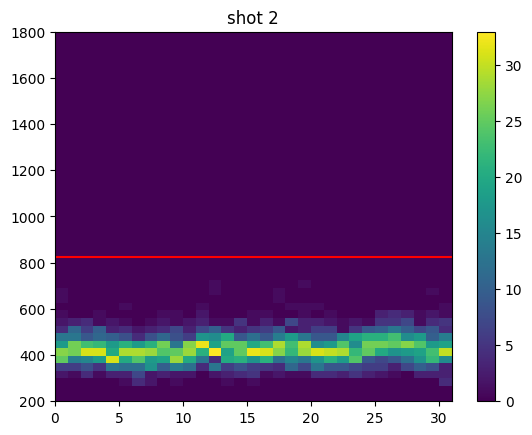

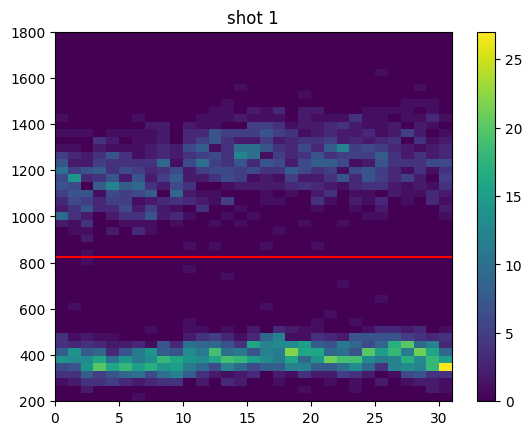

In [190]:
second_shot_hists = np.array([np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements],bins=np.linspace(200,1800,50))[0]
                              for i in range(iterations)])
fig,ax = plt.subplots()
cax=ax.imshow(second_shot_hists.transpose(),origin='lower',extent=[0,iterations,200,1800])
ax.set_title("shot 2")
ax.axhline(cutoff2,color='red')
ax.set_aspect('auto')
fig.colorbar(cax)

first_shot_hists = np.array([np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements],bins=np.linspace(200,1800,50))[0]
                              for i in range(iterations)])
fig,ax = plt.subplots()
cax=ax.imshow(first_shot_hists.transpose(),origin='lower',extent=[0,iterations,200,1800])
ax.set_title("shot 1")
ax.axhline(cutoff1,color='red')
ax.set_aspect('auto')
fig.colorbar(cax)

## 2024.04.22

## microwave spectroscopy
the atoms are hot, and we want to zero the B fields at the atoms with microwaves, but finding the microwave dip when the atoms have not been pumped into a single hyperfine state (at least partially) is going to be tough.

In [183]:
fnames = get_files_by_criteria(date_filters=["2024-04-22"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 3 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-22\11\000012226-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-22\14\000012228-GeneralVariableScan_microwave_Rabi.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-22\19\000012307-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds


In [184]:
fname = fnames[0] # checking if the FORT drift in the second readout is gone
fname = fnames[2] # finer microwave scan

f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Pumping light off? True


In [185]:
cutoff1

825.0

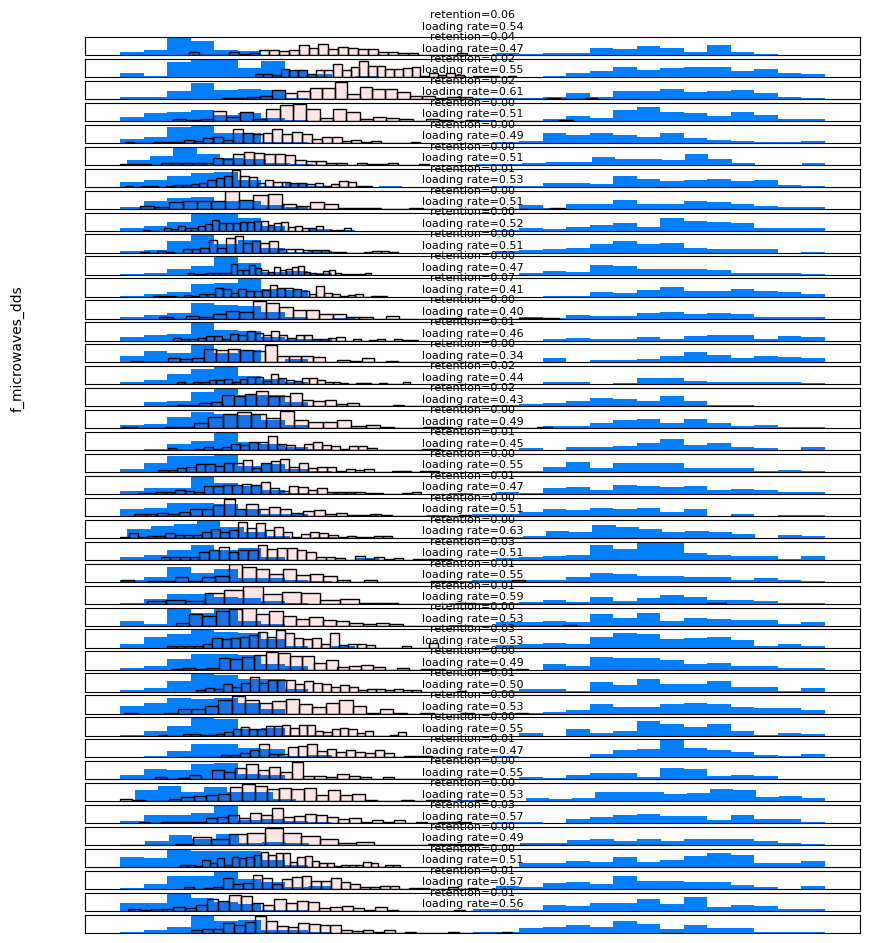

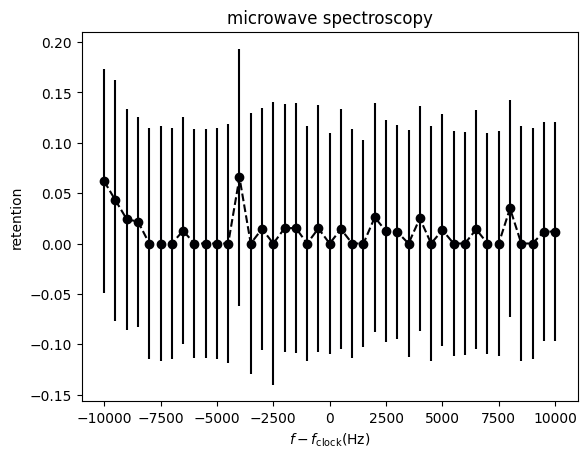

In [186]:
showhist = True
showloading = False # set to false when comparing multiple files
scan_offset = f_microwaves_dds
# scan_offset = 0

# don't try to compare multiple files if the scan is 2D
filelist=[
    # "2024-04-18\\21\\000012164-GeneralVariableScan_microwave_Rabi.h5", # shows FORT drift in second readout with single pass AOM
    fnames[2] # now we're using a double pass setup
]

user_defined_cutoffs = True
cutoff1 = cutoff2 = 800


for f_idx, fname in enumerate(filelist):
    f = h5py.File(os.path.join(results, fname))
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    iterations = len(scan_sequence1)*len(scan_sequence2)

    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    if not user_defined_cutoffs:
        cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
        cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
    if scan_is_2D:
        dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            # ax.set_ylabel("occurences")
            # ax.set_xlabel("photons")
            ax.set_xticks([])
            ax.set_yticks([])
        if scan_is_2D: # todo
            axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
            [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
            [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
            [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
        fig.text(0.45,-0.5, scan_variable2_name)
        fig.text(0.05,0.35, scan_variable1_name,rotation=90)
        plt.subplots_adjust(bottom=-0.4)
        plt.show()
    
    if scan_is_2D:
        # plot a colormap of the retention
        fig,ax = plt.subplots()
        cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                      extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
        im = ax.get_images()
        extent =  im[0].get_extent()
        # plt.setp(ax.spines.values(), linewidth=0.1)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
        ax.set_xticks(scan_sequence1)
        ax.set_yticks(scan_sequence2)
        ax.set_title(experiment_function)
        ax.set_xlabel(scan_variable1_name)
        ax.set_ylabel(scan_variable2_name)
        # ax.tick_params(axis='both', labelsize=10)
        fig.colorbar(cax)
        # plt.clim(0,1)
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if scan_is_2D:
            color=cmap(i/len(scan_sequence2))
            label=scan_variable2_name+"="+str(var2)
        else:
            color=cmap(f_idx/len(filelist))
            label=f"file {f_idx}"
        
        plt.plot(scan_sequence1-scan_offset, retention,color=color,linestyle='--')
        plt.scatter(scan_sequence1-scan_offset, retention,color=color,label=label)
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1-scan_offset, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
        # plt.xlim((-7500,-2500))
        # plt.savefig("")
    
        if len(scan_sequence2)>1 or len(filelist)>1:
            plt.legend()
        # plt.title(experiment_function)
        plt.title("microwave spectroscopy")
        # plt.savefig("first_microwave_spectroscopy_signal_expid000012164.png",bbox_inches='tight')
        # plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1-scan_offset, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            # plt.xlabel(scan_variable1_name)
            plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function)
            plt.show()
plt.show()

In [173]:
334.682 - .005

334.677

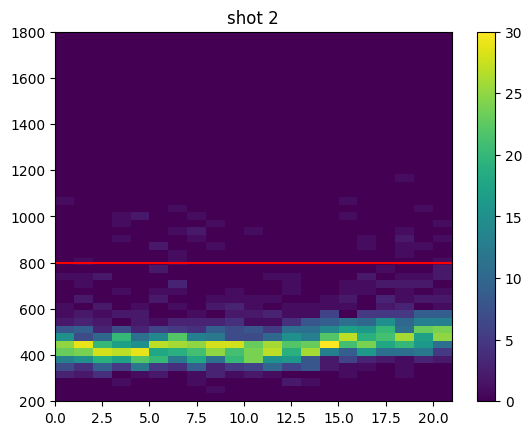

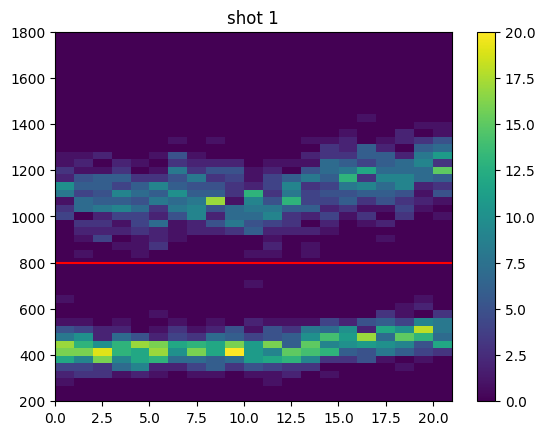

In [171]:
second_shot_hists = np.array([np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements],bins=np.linspace(200,1800,50))[0]
                              for i in range(iterations)])
fig,ax = plt.subplots()
cax=ax.imshow(second_shot_hists.transpose(),origin='lower',extent=[0,iterations,200,1800])
ax.set_title("shot 2")
ax.axhline(cutoff2,color='red')
ax.set_aspect('auto')
fig.colorbar(cax)

first_shot_hists = np.array([np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements],bins=np.linspace(200,1800,50))[0]
                              for i in range(iterations)])
fig,ax = plt.subplots()
cax=ax.imshow(first_shot_hists.transpose(),origin='lower',extent=[0,iterations,200,1800])
ax.set_title("shot 1")
ax.axhline(cutoff1,color='red')
ax.set_aspect('auto')
fig.colorbar(cax)

## 2024.04.19

## microwave spectroscopy
the atoms are hot, and we want to zero the B fields at the atoms with microwaves, but finding the microwave dip when the atoms have not been pumped into a single hyperfine state (at least partially) is going to be tough.

the scans below are not in the correct range. I forgot that the FORT gives a ~ 5 kHz differential shift around 1mK, but we haven't actually measured the trap depth yet.

In [71]:
fnames = get_files_by_criteria(date_filters=["2024-04-19"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 1 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-19\08\000012165-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds


In [144]:
fname = '2024-04-17\\22\\000012118-GeneralVariableScan_microwave_Rabi.h5' # microwave spectroscopy. shows a peak around 3.346817e+08
# fname = fnames[0] # trying to reproduce the signal we saw last night, but don't see anything


f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Pumping light off? True


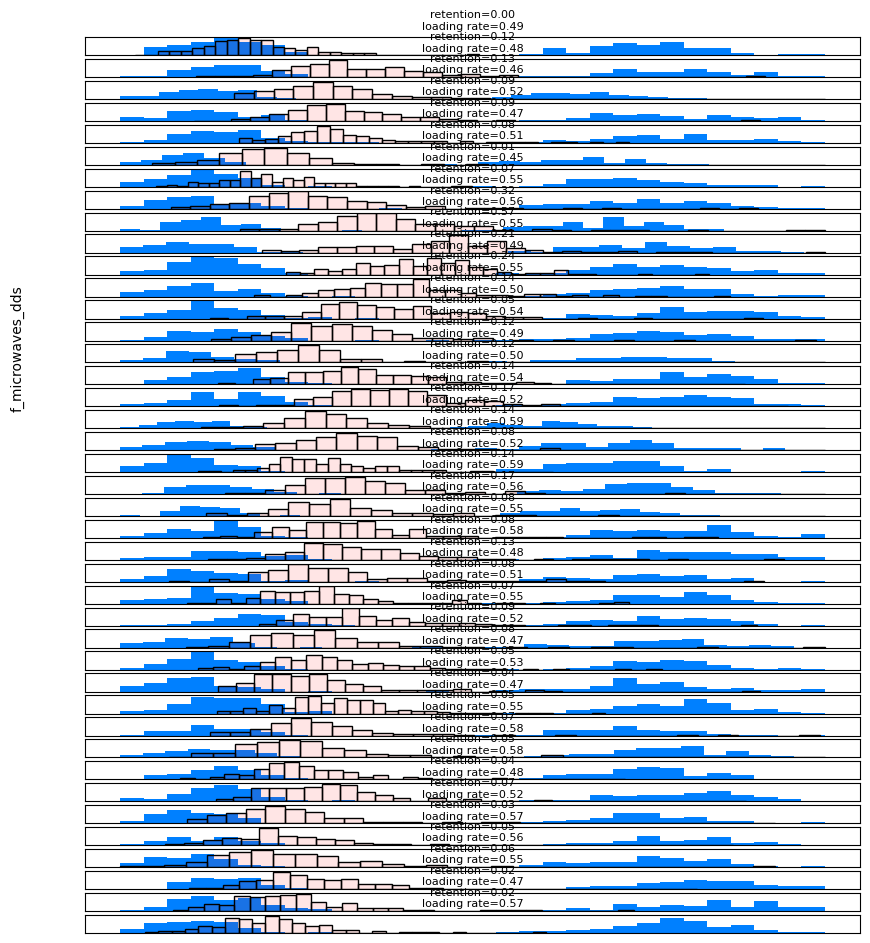

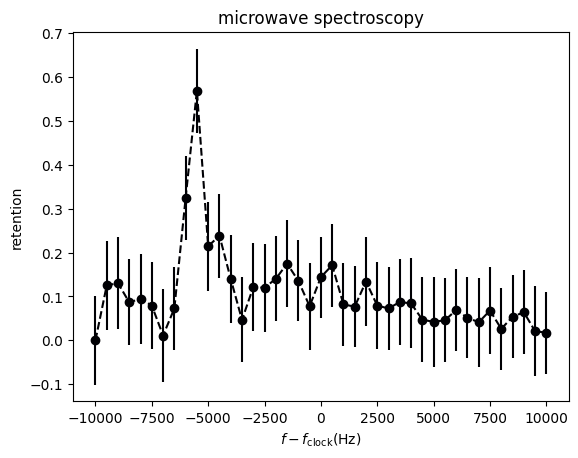

In [149]:
showhist = True
showloading = False # set to false when comparing multiple files
scan_offset = f_microwaves_dds
# scan_offset = 0

# don't try to compare multiple files if the scan is 2D
filelist=["2024-04-18\\21\\000012164-GeneralVariableScan_microwave_Rabi.h5"]#, fnames[0]]
# filelist=[fnames[0]]


for f_idx, fname in enumerate(filelist):
    f = h5py.File(os.path.join(results, fname))
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    iterations = len(scan_sequence1)*len(scan_sequence2)

    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
    cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
    if scan_is_2D:
        dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            # ax.set_ylabel("occurences")
            # ax.set_xlabel("photons")
            ax.set_xticks([])
            ax.set_yticks([])
        if scan_is_2D: # todo
            axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
            [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
            [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
            [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
        fig.text(0.45,-0.5, scan_variable2_name)
        fig.text(0.05,0.35, scan_variable1_name,rotation=90)
        plt.subplots_adjust(bottom=-0.4)
        plt.show()
    
    if scan_is_2D:
        # plot a colormap of the retention
        fig,ax = plt.subplots()
        cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                      extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
        im = ax.get_images()
        extent =  im[0].get_extent()
        # plt.setp(ax.spines.values(), linewidth=0.1)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
        ax.set_xticks(scan_sequence1)
        ax.set_yticks(scan_sequence2)
        ax.set_title(experiment_function)
        ax.set_xlabel(scan_variable1_name)
        ax.set_ylabel(scan_variable2_name)
        # ax.tick_params(axis='both', labelsize=10)
        fig.colorbar(cax)
        # plt.clim(0,1)
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if scan_is_2D:
            color=cmap(i/len(scan_sequence2))
            label=scan_variable2_name+"="+str(var2)
        else:
            color=cmap(f_idx/len(filelist))
            label=f"file {f_idx}"
        
        plt.plot(scan_sequence1-scan_offset, retention,color=color,linestyle='--')
        plt.scatter(scan_sequence1-scan_offset, retention,color=color,label=label)
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1-scan_offset, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
        # plt.xlim((-7500,-2500))
        # plt.savefig("")
    
        if len(scan_sequence2)>1 or len(filelist)>1:
            plt.legend()
        # plt.title(experiment_function)
        plt.title("microwave spectroscopy")
        # plt.savefig("first_microwave_spectroscopy_signal_expid000012164.png",bbox_inches='tight')
        # plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1-scan_offset, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            # plt.xlabel(scan_variable1_name)
            plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function)
            plt.show()
plt.show()

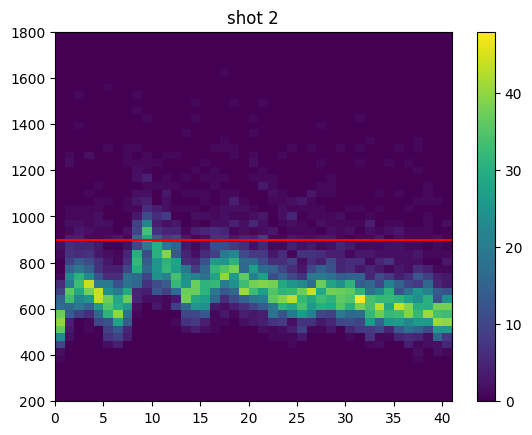

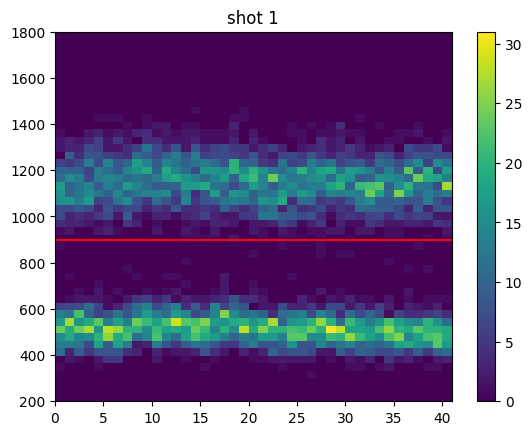

In [150]:
second_shot_hists = np.array([np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements],bins=np.linspace(200,1800,50))[0]
                              for i in range(iterations)])
fig,ax = plt.subplots()
cax=ax.imshow(second_shot_hists.transpose(),origin='lower',extent=[0,iterations,200,1800])
ax.set_title("shot 2")
ax.axhline(cutoff2,color='red')
ax.set_aspect('auto')
fig.colorbar(cax)

first_shot_hists = np.array([np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements],bins=np.linspace(200,1800,50))[0]
                              for i in range(iterations)])
fig,ax = plt.subplots()
cax=ax.imshow(first_shot_hists.transpose(),origin='lower',extent=[0,iterations,200,1800])
ax.set_title("shot 1")
ax.axhline(cutoff1,color='red')
ax.set_aspect('auto')
fig.colorbar(cax)

## 2024.04.18

## microwave spectroscopy
the atoms are hot, and we want to zero the B fields at the atoms with microwaves, but finding the microwave dip when the atoms have not been pumped into a single hyperfine state (at least partially) is going to be tough.

the scans below are not in the correct range. I forgot that the FORT gives a ~ 5 kHz differential shift around 1mK, but we haven't actually measured the trap depth yet.

In [50]:
fnames = get_files_by_criteria(date_filters=["2024-04-18"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 7 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-18\08\000012119-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-18\10\000012136-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-18\11\000012139-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-18\11\000012140-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-18\13\000012142-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-18\18\000012163-GeneralVariableScan_microwave_Rabi.h5) scanned over f_microwaves_dds
file 6 (C:\Networking Experiment

In [51]:
fname = 'C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\2024-04-17\\22\\000012118-GeneralVariableScan_microwave_Rabi.h5' # microwave spectroscopy. shows a peak around 3.346817e+08
fname = fnames[0] # check if the peak was real. poor statistics-- try again. 
fname = fnames[1] 
fname = fnames[2] # maybe shows a peak around 384.68 MHz + 6.25 kHz
fname = fnames[6] # FOUND IT! VERY CLEAR MICROWAVE PEAK. 

f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Pumping light off? True


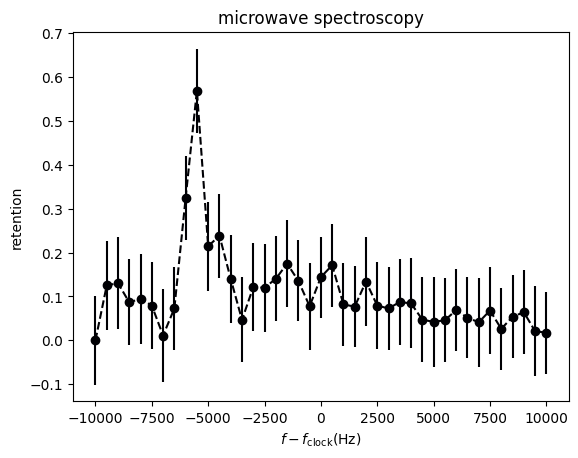

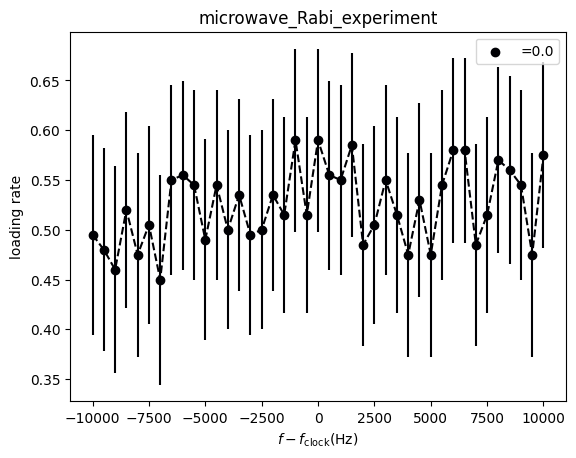

In [67]:
showhist = False
showloading = True
scan_offset = f_microwaves_dds
# scan_offset = 0

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2_name)
    fig.text(0.05,0.35, scan_variable1_name,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_function)
    ax.set_xlabel(scan_variable1_name)
    ax.set_ylabel(scan_variable2_name)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1-scan_offset, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1-scan_offset, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1-scan_offset, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
    plt.savefig("")

    if len(scan_sequence2)>1:
        plt.legend()
    # plt.title(experiment_function)
    plt.title("microwave spectroscopy")
    plt.savefig("first_microwave_spectroscopy_signal_expid000012164.png",bbox_inches='tight')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1-scan_offset, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1-scan_offset, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        # plt.xlabel(scan_variable1_name)
        plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function)
        plt.show()

In [60]:
len(scan_sequence2)

1

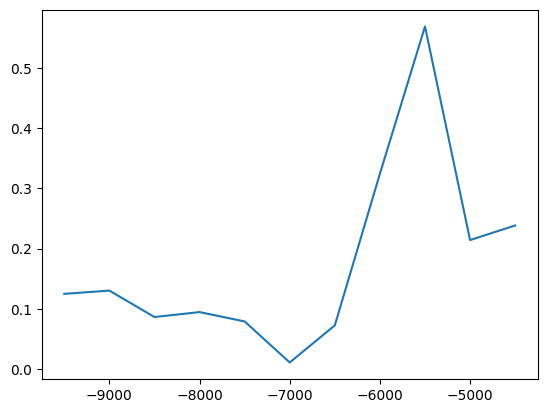

In [63]:
plt.plot(scan_sequence1[1:12]-f_microwaves_dds,retention_array[1:12])

In [40]:
retention_array[16]

0.1111111111111111

## 2024.04.10

In [21]:
fnames = get_files_by_criteria(date_filters=["2024-04-10"], # only find files from these date directories
                               name_filters=["atom_loading"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    scan_str = str_from_h5(ds['scan_variable1_name'])
    if str_from_h5(ds['scan_variable2_name']) != '':
        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
    print(f"file {i} scanned over "+scan_str)

found 18 files
file 0 scanned over f_cooling_DP_RO
file 1 scanned over f_cooling_DP_RO
file 2 scanned over f_cooling_DP_RO
file 3 scanned over f_cooling_DP_RO
file 4 scanned over f_cooling_DP_RO
file 5 scanned over f_cooling_DP_RO
file 6 scanned over f_cooling_DP_RO
file 7 scanned over f_cooling_DP_RO
file 8 scanned over f_cooling_DP_RO
file 9 scanned over t_SPCM_first_shot
file 10 scanned over t_SPCM_first_shot
file 11 scanned over t_SPCM_first_shot
file 12 scanned over p_cooling_DP_RO
file 13 scanned over p_cooling_DP_RO
file 14 scanned over t_MOT_dissipation
file 15 scanned over dummy_variable
file 16 scanned over AX_volts_RO
file 17 scanned over AY_volts_RO


In [22]:
fname = fnames[9]

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
t_SPCM_first_shot = np.float64(f['archive']['t_SPCM_first_shot'])
t_SPCM_second_shot = np.float64(f['archive']['t_SPCM_second_shot'])
single_atom_counts_per_s = np.uint(f['archive']['single_atom_counts_per_s'])

scan_variable1 = str_from_h5(f['datasets']['scan_variable1_name'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

try:
    scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
except:
    scan_sequence1 = np.array(f['datasets']['scan_sequence1'])

scan_variable2 = str_from_h5(f['datasets']['scan_variable2_name'])
if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: atom_loading_experiment
t_SPCM_first_shot [0.007      0.00844444 0.00988889 0.01133333 0.01277778 0.01422222
 0.01566667 0.01711111 0.01855556 0.02      ]
 [0.]


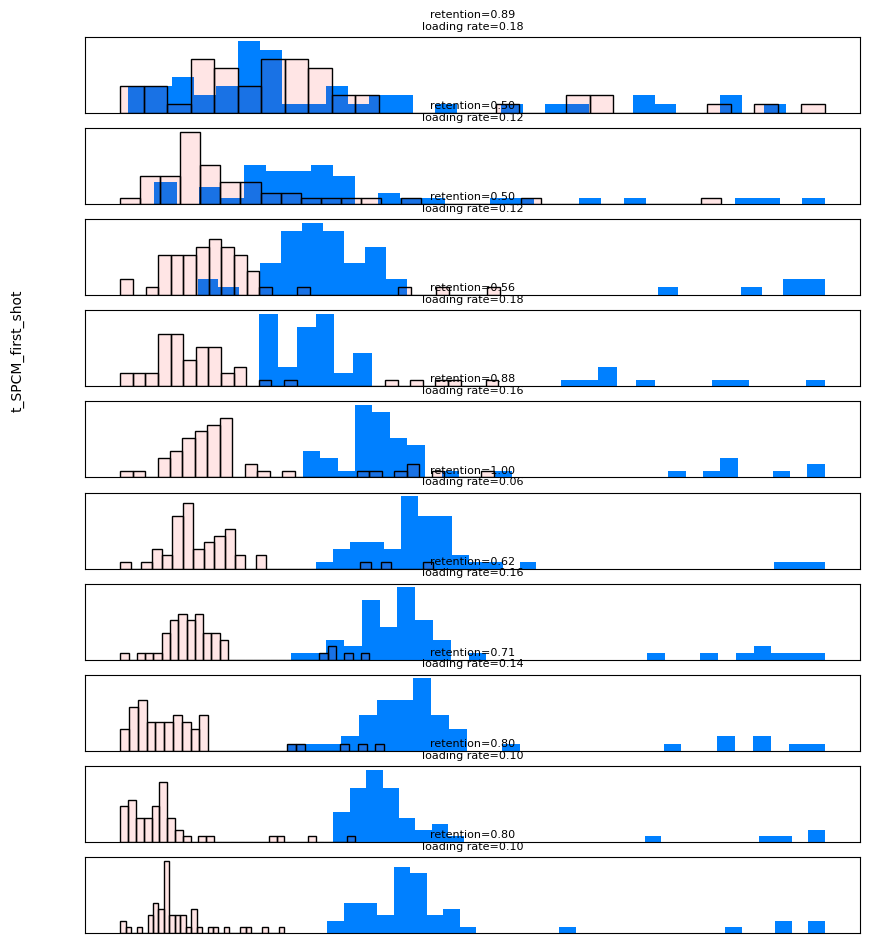

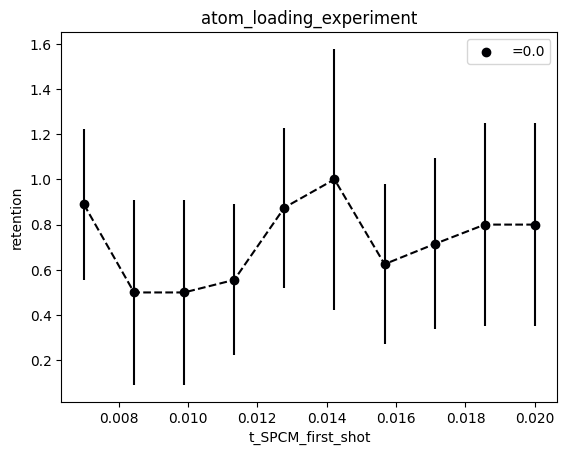

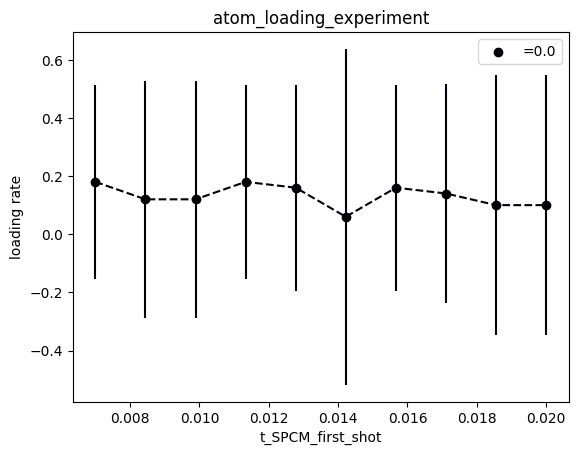

In [23]:
# caution: don't copy the cell below for other variable scans, since the readout time t_SCPM_first_shot changes how we calculate the atom theshold for each step

showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]

    # THIS IS ONLY VALID IF WE ARE SCANNING THE FIRST READOUT TIME
    cutoff1 = single_atom_counts_per_s*scan_sequence1[i]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()

## scan over readout detuning - just testing this notebook

In [16]:
fname = fnames[7]

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
t_SPCM_first_shot = np.float64(f['archive']['t_SPCM_first_shot'])
t_SPCM_second_shot = np.float64(f['archive']['t_SPCM_second_shot'])
single_atom_counts_per_s = np.uint(f['archive']['single_atom_counts_per_s'])

scan_variable1 = str_from_h5(f['datasets']['scan_variable1_name'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

try:
    scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
except:
    scan_sequence1 = np.array(f['datasets']['scan_sequence1'])

scan_variable2 = str_from_h5(f['datasets']['scan_variable2_name'])
if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: atom_loading_experiment
f_cooling_DP_RO [1.20e+08 1.21e+08 1.22e+08 1.23e+08 1.24e+08 1.25e+08]
 [0.]


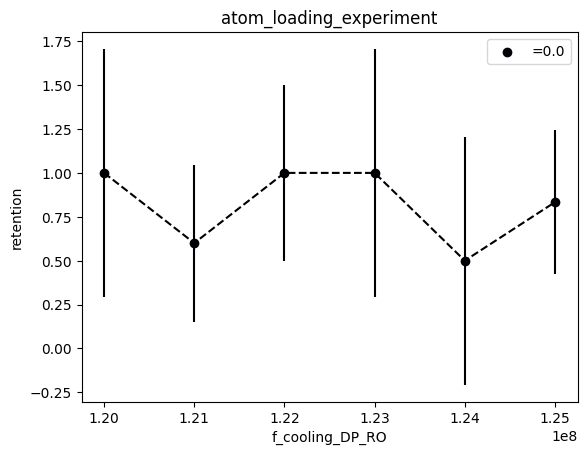

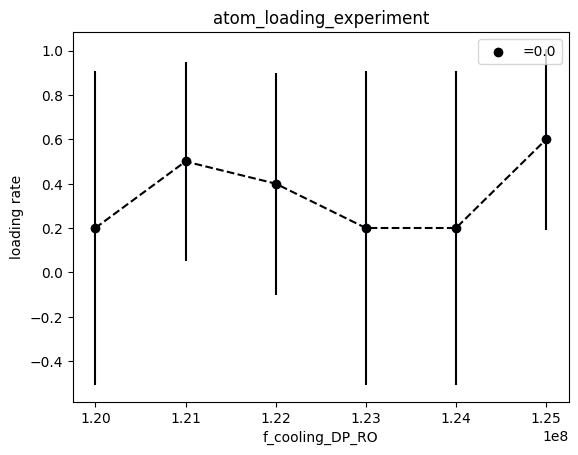

In [17]:
showhist = False
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()